# Homework 4 solution
- INFO 4871 / 5871
- Spring 2019
- Professor Robin Burke
- Edited by Juan Vargas-Murillo

## Objective (all students)
The object of this assignment is to gain familiarity with content-based recommendation algorithms. You will do this by implementing a simple hybrid recommender system and evaluating it relative to its components. I have provided the following:
- An outline of the NaiveBayesRecommender class. 
- A test case for the NaiveBayesRecommender class

You will first implement the NaiveBayesRecommender. It takes an item-feature table and produces a set of tables counting the user / feature / like (~like) combinations. 

Then you will use the algorithm to generate content-based recommendations for the MovieLens dataset using the "genre" values found in the movie table, and evaluate based on precision @ 10 compared to the item-item recommender.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Predictor, Recommender
from lenskit.algorithms.item_knn import ItemItem


## Import NaiveBayesRecommender
Use autoimport to support development of the NaiveBayes code

In [4]:
%load_ext autoreload
%aimport naive_bayes
%autoreload 2

from naive_bayes import NaiveBayesRecommender

In [5]:
import unittest
from test_naive_bayes import test_NaiveBayes

%aimport test_naive_bayes

### Running unit tests

In [5]:
suite = unittest.TestLoader().loadTestsFromTestCase(test_naive_bayes.test_NaiveBayes)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_cond_prob (test_naive_bayes.test_NaiveBayes) ... ok
test_cond_tables (test_naive_bayes.test_NaiveBayes) ... ok
test_liked_prob (test_naive_bayes.test_NaiveBayes) ... ok
test_liked_tables (test_naive_bayes.test_NaiveBayes) ... ok
test_pred1 (test_naive_bayes.test_NaiveBayes) ... ok
test_pred2 (test_naive_bayes.test_NaiveBayes) ... ok
test_pred3 (test_naive_bayes.test_NaiveBayes) ... ok
test_recommend (test_naive_bayes.test_NaiveBayes) ... ok
test_reset (test_naive_bayes.test_NaiveBayes) ... ok
test_zeros (test_naive_bayes.test_NaiveBayes) ... ok

----------------------------------------------------------------------
Ran 10 tests in 0.864s

OK


<unittest.runner.TextTestResult run=10 errors=0 failures=0>

## Evaluation
Load ratings

In [7]:
ratings = pd.read_csv('ml_ratings.csv', encoding='Latin 1')
ratings.columns = ['user', 'item', 'rating', 'timestamp']

In [8]:
ratings.head()

,user,item,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [9]:
len(ratings)

264505

In [10]:
ratings.user.unique()

array([ 12882,    320, 121987,  62046,  18127,  17318, 103754,  69519,
       124823, 115611,   8932,  48821,  54114,   9745,  65155,  68702,
       108195, 137209, 119330,  86784, 137609, 120067, 108922,    316,
        67608, 100277,   5268,  33173,  64100,  37091,  64150,  88266,
        35823, 108159,  82715,  68836,  14833,  45371, 124078,  67615,
        53113,  30631, 132295, 125171,  26674,  84948,  45854,  40071,
        92430,  32215,  31476, 102549,  69498,   9991,  53930, 132229,
        22245,  11337,  21401,  46645, 103872, 119309, 131835,  43354,
        36624, 104037, 137805,  57387,  40652,  59163, 125889, 128111,
        18204,  93619,  41518, 130589, 124425,  28340, 113540,  10164,
        16559,  77512,  57937,  15415,  41557, 131439,  47150,  13700,
        11571,  79846,  92861, 102750,  49642, 117861, 136455,  12778,
        16337,   3665,  91973,  86449,  87075, 115364, 125207, 125984,
         4931,  58802,   7723,  92106,  62732,   3029, 109970,  74730,
      

In [13]:
len(movies)

2500

Load movie information

In [12]:
movies = pd.read_csv('ml_movies.csv', encoding='Latin 1')
movies.columns = ['item', 'title', 'genres']
movies.head()

,item,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
len(movies)

2500

### Genre
Split out genres into a separate data frame with "Item", "Feature" columns.

In [10]:
item_feature_tuple_list = []
for row in movies.itertuples():
    features = row[-1].split("|")
    for feature in features:
        item_feature_pair = (row[1], feature)
        item_feature_tuple_list.append(item_feature_pair)


# def split_and_pair_feature_to_item(features, item):
#     pairs = []
#     for feature in features.split("|"):
#         pairs.append((item, feature))
        
# features = movies.apply(split_and_pair_feature_to_item(movies['features'], movies['item']))

In [11]:
features = pd.DataFrame(item_feature_tuple_list, columns=['item','feature'])

In [12]:
features.head()

,item,feature
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


,item,feature
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


## Instantiate algorithms
### Naive Bayes
Like / dislike threshold = 2.9
alpha = 0.01
beta = 0.02

In [13]:
nb = NaiveBayesRecommender(thresh=2.9, alpha=0.01, beta=0.02,item_features=features)

### Item-based knn
neighbors = 20
minimum similarity = 0
center = True
aggregate = weighted-average

In [14]:
item_knn = ItemItem(nnbrs=20, min_sim=0, center=True, aggregate='weighted-average')

Supplied: eval_recs

In [15]:
def eval_recs(aname, fold, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    
    users = test.user.unique()
    recs = batch.recommend(fittable, users, 10)
    # add the algorithm
    recs['Algorithm'] = aname
    recs['Fold'] = fold
    return recs

5-fold cross-validation

In [16]:
np.random.seed(20190317)

all_recs1 = []
test_data1 = []
fold = 0
# 5 fold cross-validation
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    # Implement 5-fold cross-validation with user-based splitting
    # Call eval_recs for each algorithm, each fold
    # Results should be appended to all_recs
    # Test data should be a list
    test_data1.append(test)
    all_recs1.append(eval_recs('NaiveBayes', fold, nb, train, test))
    all_recs1.append(eval_recs('ItemItem', fold, item_knn, train, test))
    print("Completed fold {}".format(fold))
    fold += 1

Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4


Put answers together

In [17]:
all_recs1 = pd.concat(all_recs1, ignore_index=True)
test_data1 = pd.concat(test_data1, ignore_index=True)

Run evaluation with precision

In [19]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.precision)

A = all_recs1.groupby(['Algorithm','Fold']).apply(lambda df: rla.compute(df, test_data1))

B = A.groupby(['Algorithm', 'Fold']).mean()
C = B.groupby(['Algorithm']).agg([np.mean, np.std])

C

precision          
                mean       std
Algorithm                     
ItemItem    0.117266  0.010401
NaiveBayes  0.030858  0.007944

precision          
                mean       std
Algorithm                     
ItemKnn     0.117266  0.010401
NaiveBayes  0.041514  0.002068

Plot using a bar chart with error bars as in Homework 3

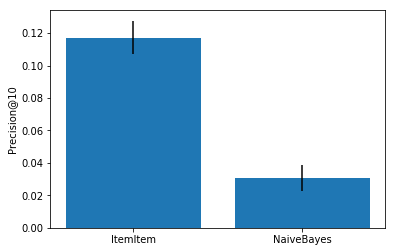

In [20]:
algos = [i for i in C.index]
p_means = [p for p in C['precision']['mean']]
p_std = [s for s in C['precision']['std']]

plt.bar(algos, p_means, yerr=p_std)
plt.ylabel('Precision@10')

plt.show()

Text(0, 0.5, 'precision@10')

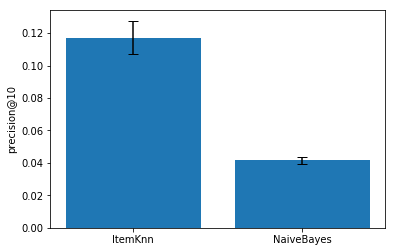

### Question
You can see that the content-based recommender has lower precision@10 than the collaborative one. Do you think that a weighted hybrid of these two methods would be better than the collaborative one alone? Justify your answer.

### Answer
Yes, using a weighted hybrid with both ItemKNN and NaiveBayes would provide a higher precision than just using one method alone. With NaiveBayes as one method in the weighted hybrid, we would be incorporating the content-based information of each item to add on top of the item similarity that the ItemKNN method is calculating.  

## Using tags as content (INFO 5871)
Here you will use the same implementation as above, but you will use a different set of content data -- the tags from `ml_tags.csv`.

,movieId,userId,tag,timestamp
0,3916,12882,sports,1147195545
1,4085,12882,Eddie Murphy,1147195966
2,33660,12882,boxing,1147195514
3,1197,320,must show,1145964801
4,1396,320,must show,1145964810


Calculate entropy of tag collection

$e_{tag} = - p_{tag} \log_{2} p_{tag}$

$p_{tag}$ = count of tag occurence / number of tagging events

,prob,entropy
tag,,
"""A MÃ£o-de-Deus""",0.000011,0.000174
"""Duck and cover!""",0.000011,0.000174
"""I need a computer.""",0.000011,0.000174
"""The Hunter""",0.000011,0.000174
"""bitchy""",0.000011,0.000174


Drop tags with entropy <= 0.001. (There aren't tags with high entropy, so we won't filter for that.)

Use this set of tags to filtering the original tag data so that it only includes the tags with higher entropy.

,prob,entropy,movieId,userId,timestamp
tag,,,,,
"""damn dirty apes""",0.000116,0.001516,2529,27898,1279147178
"""damn dirty apes""",0.000116,0.001516,2530,10514,1341510171
"""damn dirty apes""",0.000116,0.001516,2530,134156,1181700629
"""damn dirty apes""",0.000116,0.001516,2531,134156,1181700651
"""damn dirty apes""",0.000116,0.001516,2533,134156,1181700658


Convert filtered tag data to collection of features for the content-based recommender

In [22]:
tag_features.head()

,item,feature
0,2529,"""damn dirty apes"""
1,2530,"""damn dirty apes"""
2,2530,"""damn dirty apes"""
3,2531,"""damn dirty apes"""
4,2533,"""damn dirty apes"""


Create the NaiveBayesRecommender with these features. thresh=2.9, alpha=0.01, beta=0.02

Run the evaluation

In [ ]:
np.random.seed(20190317)

all_recs2 = []
test_data2 = []
fold = 0
# Evaluation code here
    fold += 1

Assemble the results data

In [25]:
all_recs2 = pd.concat(all_recs2, ignore_index=True)
test_data2 = pd.concat(test_data2, ignore_index=True)

Compute precision at 10.

precision          
                mean       std
Algorithm                     
NaiveBayes  0.212385  0.008791

Combine with the results from part 1

precision          
               mean       std
Algorithm                    
ItemKnn    0.117266  0.010401
Genre      0.041514  0.002068
Tags       0.212385  0.008791

Plot all three results as a bar plot with error bars.

Text(0, 0.5, 'precision@10')

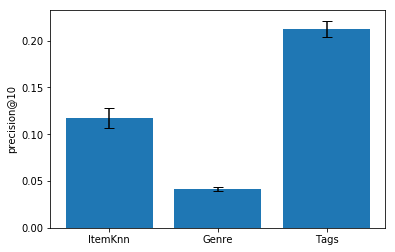

### Question
You will see that the tags form a better basis for content-based recommendation than the genre data and even better than the collaborative recommender. Why do you think this is the case here when the genre-based method was not as good? 

### Answer
_your answer here_